In [19]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfilename
import csv
from pathlib import Path
import pymongo
import numpy as np
# Use sentinel for missing values
from numpy import nan as NA
import pandas as pd
# For showing plots in tkinter
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  
NavigationToolbar2Tk) 
import seaborn as sns
import tkinter.constants as Tkconstants

# connect to mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
# create db
db_formative = client["summative"]
# create collection
collection_vendors = db_formative["test-116"]

In [11]:
fileButtons = ["inspections", "inventory", "violations"]
fileRoutes = {fileButtons[0]:"", fileButtons[1]:"", fileButtons[2]:""}

In [12]:
class Parser(object):
    def __init__(self, collection, csvFile):
        self.collection = collection
        self.csvFile = csvFile
        self.inspectionsDF = None
        self.inventoryDF = None
        self.violationsDF = None
        
    def parseData(self):
        # Read CSV files and convert to Pandas DataFrames
        self.inspectionsDF = pd.read_csv(self.csvFile['inspections'])
        self.inventoryDF = pd.read_csv(self.csvFile['inventory'])
        self.violationsDF = pd.read_csv(self.csvFile['violations'])
        
        return self.inspectionsDF, self.inventoryDF, self.violationsDF
                

In [13]:
class DataCleaner(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def clean(self):
        print('cleaning')
        self.cleanInspections()
        return self.inspectionsDF, self.inventoryDF, self.violationsDF
        
    def cleanInspections(self):
        # Extract info from PE DESC column and create new col for SEATING DETAILS
        self.inspectionsDF['SEATING DETAILS'] = self.inspectionsDF['PE DESCRIPTION'].str.extract(r"\(([\S ]+)\)")
        print(f'seating deats \n{self.inspectionsDF["SEATING DETAILS"]}')
        print(f'pe desc \n{self.inspectionsDF["PE DESCRIPTION"]}')
        # Extract first part of Zip Code (e.g. '90001-1234', becomes '90001')
        self.inspectionsDF['FACILITY ZIP'] = self.inspectionsDF['FACILITY ZIP'].str.extract(r"([0-9]+)") 
        # Add '_id' for MongoDB      
        self.inspectionsDF['_id'] = 'INS_' + self.inspectionsDF['SERIAL NUMBER']


In [14]:
class DataLoader():
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def loadToMongo(self):
        # use to_dict to format correctly for MongoDB
        inspectionsDict = self.inspectionsDF.to_dict(orient='records')
        inventoryDict = self.inventoryDF.to_dict(orient='records')
        violationsDict = self.violationsDF.to_dict(orient='records')
        # Insert into Mongo
        collection_vendors.insert_many(inspectionsDict)
        collection_vendors.insert_many(inventoryDict)
        collection_vendors.insert_many(violationsDict)
        # Embed violations
        self.formatViolations()
        # Test db
        test = collection_vendors.find({'_id':{'$regex':'INS_'}})
        for t in test:
            print(f'testing inspections: \n{t}')
            break
        print('inserted into Mongo')
        
    def formatViolations(self):
        # Add violations as embedded docs to inspections
        print('start cleaning violations')
        # Find all inspections
        resultsViolations = collection_vendors.find({'VIOLATION DESCRIPTION':{'$regex':'#'}})
        for result in resultsViolations:
            collection_vendors.update_one({'_id':{'$regex':'INS_'},'SERIAL NUMBER': result['SERIAL NUMBER']}, {'$addToSet': {'VIOLATIONS': result}})
        print('finish cleaning violations')
           

In [15]:
class ButtonUpload(object):
    def __init__(self, fileButtons, fileLabels, counter, mainframe):
        self.fileButtons = fileButtons
        self.fileLabels = fileLabels
        self.counter = counter
        self.mainframe = mainframe
        self.filePath = ''
        self.uploadLabel = StringVar()

    def browseFile(self):
        self.filePath = askopenfilename(filetypes=[("CSV files", ".csv")])
        fileName = Path(self.filePath)
        self.uploadLabel.set(fileName.name)
        print(self.filePath)
        self.setFileRoutes()
    
    def setFileRoutes(self):
        fileRoutes[self.fileButtons] = self.filePath
        print(fileRoutes)
        
    def createButton(self):
        ttk.Label(self.mainframe, text=f"Upload data: {self.fileButtons}", anchor="w").grid(row=self.counter+1, column=0, sticky="w")
        Button(self.mainframe, text="Upload file", command=self.browseFile).grid(row=self.counter+1, column=1, sticky="w")
        ttk.Label(self.mainframe, textvariable=self.uploadLabel).grid(row=self.counter+1, column=2, sticky="w") 
        

In [16]:
class AveragesCalculator(object):
    def __init__(self, year, category):
        self.year = year
        self.category = category
        
    def zipScores(self):
        print(f'Calculating stats for: \n- Year = {self.year} \n- Category = {self.category}')
        # Find inspection documents - look in ispections (INS_) with year
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'},'ACTIVITY DATE':{'$regex':self.year}, 'PROGRAM STATUS': 'ACTIVE'})

        # Create dict of facility zips with lists of their scores
        zipScoresDict = {}  
        for r in resultsInspections:
            key = r[self.category]
            if key in zipScoresDict:
                zipScoresDict[r[self.category]].append(r['SCORE'])
            else:
                zipScoresDict[key] = [r['SCORE']]
        return self.calcZipStats(zipScoresDict)


    def calcZipStats(self, zipScoresDict):
        zipScoresMean = {}
        zipScoresMean = {self.category:[],'mean':[],'median':[],'mode':[]}
        for x in zipScoresDict:
            # Create Series to calc mean, mode, median
            tempSeries = pd.Series(zipScoresDict[x])
            mean = tempSeries.mean()
            mode = tempSeries.mode().tolist()
            median = tempSeries.median()

            # mean, mode, median as columns
            zipScoresMean[self.category].append(x)
            zipScoresMean['mean'].append(mean)
            zipScoresMean['median'].append(median)
            zipScoresMean['mode'].append(mode)

        # Create DataFrame
        zipScoresDF = pd.DataFrame(zipScoresMean)
        # sort by ascending cat - easier to find for user (esp. zip)
        zipScoresDF.sort_values(by=[self.category],inplace=True)
        # set cat as index
        zipScores_noIndex = zipScoresDF.set_index(self.category)
        
        return zipScores_noIndex
 

In [20]:
class UserInterface(object):
    def __init__(self, title):
        self.title = title
        self.mainframe = None
        self.window = Tk()
        self.window.title(self.title)
        self.window.geometry("1200x800")
        self.window.columnconfigure(0, weight=1)
        self.window.rowconfigure(0, weight=1)
        self.calcCategory = StringVar()
        self.calcYear = StringVar()
        self.dataDict = None
        self.violationsDF = None
        self.window.rowconfigure( 0, weight=1 )     # You need to add this. 
        self.window.columnconfigure( 0, weight=1 )  # You need to add this.
        self.cleanedData = None
        
    def createWindow(self):
        self.createInitialFrame()
        self.window.mainloop()
        
    def createInitialFrame(self):
         # variables
        labelTextOne = StringVar()
        labelTextTwo = StringVar()
        labelTextThree = StringVar()
        fileLabels = [labelTextOne, labelTextTwo, labelTextThree]
        # Config layout
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        self.mainframe.grid_rowconfigure(4, weight=1)
        self.mainframe.grid_columnconfigure(2, weight=1)
        heading = ttk.Label(self.mainframe, text="Load your dataset", anchor="w").grid(row=0, sticky="nw")
        # Create buttons for file uploads
        for i in range(0, len(fileButtons)): 
            newButton = ButtonUpload(fileButtons[i], fileLabels[i], i, self.mainframe)
            newButton.createButton()
        # Buttons for Cancel and Clean & Save
        footer = ttk.Frame(self.window, padding="16 0 0 0").grid(row=5, column=1)
        cancelButton = Button(self.mainframe, text="Cancel & exit", bg="red").grid(row=4, column=0, sticky="sw")
        saveButton = Button(self.mainframe, text="Load & clean dataset", command=self.handleSave).grid(row=4, column=2,sticky="se")
        
    def handleSave(self):
        # parse data
        parser = Parser(collection_vendors, fileRoutes)
        parsedData = parser.parseData()
        self.violationsDF = parsedData[2]
        # Clean data - pass data returned from parser
        cleaner = DataCleaner(*parsedData)
        self.cleanedData = cleaner.clean()
        print('done uploadFrame')
        self.uploadFrame()
        
    def uploadFrame(self):
        self.mainframe.destroy()
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        heading = ttk.Label(self.mainframe, text="The data has been prepared and cleaned.", anchor="w").grid(row=0, sticky="nw")
        subheading = ttk.Label(self.mainframe, text="Please press continue to load data to MongoDB and proceed.", anchor="w").grid(row=1, sticky="nw")
        saveButton = Button(self.mainframe, text="Continue", command=self.handleLoadToDB).grid(row=2 ,sticky="nw")
        
    def handleLoadToDB(self):
        # Insert to MongoDB - pass data returned from cleaner
        loader = DataLoader(*self.cleanedData)
        loader.loadToMongo()
        print('done handleLoadToDB')
        self.createNotebook()
        
    def createNotebook(self):
        print('Creating Notebook (Tabs)')
        self.mainframe.destroy()
        self.mainframe = ttk.Notebook(self.window)
        f1 = ttk.Frame(self.mainframe)  
        f2 = ttk.Frame(self.mainframe)  
        f3 = ttk.Frame(self.mainframe) 
        self.mainframe.add(f1, text='Averages')
        self.mainframe.add(f2, text='Violations per Establishment')
        self.mainframe.add(f3, text='Correlations')
        # ====== Widget for tab 1
        heading_one = ttk.Label(f1, text="Mean, Mode and Median", anchor="w").grid(row=0, sticky="nw")
        # Radio - Type
        radioHeadingOne = ttk.Label(f1, text="Calculate by seating type or zip codes:", anchor="w").grid(row=0, sticky="nw")
        Radiobutton(f1, text="Vendor seating type", padx = 20, variable=self.calcCategory, value='SEATING DETAILS').grid(row=1, column=0, sticky='w')
        Radiobutton(f1, text="Zip Code", padx = 20, variable=self.calcCategory, value='FACILITY ZIP').grid(row=2, column=0, sticky='w')
        # Radio - Years
        radioHeadingTwo = ttk.Label(f1, text="Select Year", anchor="w").grid(row=3, sticky="nw")
        yearsArr = ['2016', '2017', '2018', '2019']
        for i in range(len(yearsArr)):
            Radiobutton(f1, text=yearsArr[i], padx = 20, variable=self.calcYear, value=yearsArr[i]).grid(row=i+4, column=0, sticky='w')
        # Calc button
        calcButton = Button(f1, text="Calculate", command=self.calcAverages).grid(row=8, column=0, sticky="sw")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        
        # ====== Widget for tab 2
        heading_two = ttk.Label(f2, text="Violations per Establishment", anchor="w").grid(row=0, sticky="nw")
        self.createViolationsPlot(f2)
        
        # ====== Widget for tab 3
        heading_two = ttk.Label(f3, text="Correlation between the number of violations commited per vendor and their zip code", anchor="w").grid(row=0, sticky="nw")
        correlationsButton = Button(f3, text="Show correlations plot", command=self.createCorrelationsPlot).grid(row=1, column=0, sticky="sw")
        
    def createViolationsPlot(self, f2):
        # Create dict with violation codes as keys and no. of facilities that commited that violation as values
        vioDict = {}
        # Sort the violation codes for easier reading for user
        violationsList = self.violationsDF['VIOLATION CODE'].unique()
        sortedCodes = sorted(violationsList)
        for v in sortedCodes:
            resultsInspections = collection_vendors.find({'VIOLATIONS.VIOLATION CODE':v}, {'FACILITY NAME':1})
            # Hash map to see if facility has been included - only need ONE instance of violation per facility
            facilityNames = {}
            for r in resultsInspections:
                # if facility name has already been counted, continue to next loop
                if r['FACILITY NAME'] in facilityNames:
                    continue
                # else, facility name has not yet been counted, add appropriately
                else:
                    if v in vioDict:
                        vioDict[v] = vioDict[v] + 1
                    else:
                        vioDict[v] = 1

        
        # Display violations vs no. of establishments
        vioKeys = list(vioDict.keys())
        vioVals = list(vioDict.values())
        # Create 4 subplots using slices of the keys & values lists
        fig,a =  plt.subplots(2,2)
        a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
        a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
        a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
        a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
        # Show in console as well as window
        plt.show()

        # creating the Tkinter canvas containing the Matplotlib figure 
        canvas = FigureCanvasTkAgg(fig, master = f2)   
        canvas.draw() 

        # grid the canvas on the Tkinter window 
        canvas.get_tk_widget().place(relheight=1, relwidth=1) 
        
    def createCorrelationsPlot(self):
        # Find number of violations per vendor, and their zip code
        insVios = collection_vendors.find({'_id':{'$regex':'INS_'}, 'PROGRAM STATUS': 'ACTIVE'}, {'FACILITY ID':1,'VIOLATIONS':1, 'FACILITY ZIP':1})
        # 
        insViosDict = {}
        for r in insVios:
            if 'VIOLATIONS' in r:

                if r['FACILITY ID'] in insViosDict:
                    insViosDict[r['FACILITY ID']]['quant'] = insViosDict[r['FACILITY ID']]['quant'] + len(r['VIOLATIONS'])
                else:
                    insViosDict[r['FACILITY ID']] = {}
                    insViosDict[r['FACILITY ID']]['quant'] = len(r['VIOLATIONS'])
                    insViosDict[r['FACILITY ID']]['zip'] = r['FACILITY ZIP']

        total = {'quantity':[], 'zip': []}
        for x in insViosDict:
            total['quantity'].append(int(insViosDict[x]['quant']))
            total['zip'].append('. '+insViosDict[x]['zip'])
            type(total['quantity'])

        type(total['quantity'][0]) 
                
        #  Create DataFrame - sorted by zip to make visualisations easier to understand
        insViosDF = pd.DataFrame(total)
        insViosDF.sort_values(by=['quantity'],inplace=True)
        
        # New window
        window = Tk()
        window.title(self.title)
        window.geometry("1200x800")
        window.columnconfigure(0, weight=1)
        window.rowconfigure(0, weight=1)
        
        # Scroll Y
        frame=Frame(window)
        frame.grid(row=0,column=0)
        frame.columnconfigure(0, weight=1)
        frame.rowconfigure(0, weight=1)
        canvas = Canvas(frame)
        canvas.grid(row=0, column=0, sticky=Tkconstants.NSEW)
        yScrollbar = Scrollbar(frame)
        yScrollbar.grid(row=0, column=1, sticky=Tkconstants.NS)
        canvas.config(yscrollcommand=yScrollbar.set)
        yScrollbar.config(command=canvas.yview)
        
        
        # Creating the figure and Seaborn plot
        figure = Figure(figsize=(8, 30))
        ax = figure.subplots()
        sns.barplot(x="quantity", y="zip", data=insViosDF, label="Total", color="b", ax=ax)
        
        # create the Tkinter canvas 
        canvasInner = FigureCanvasTkAgg(figure, master = canvas)   
        canvasInner.draw() 

        # place the canvas on the Tkinter window 
        mplCanvas = canvasInner.get_tk_widget()
        
        cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
        canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=800,height=800)
        
#         window.mainloop()
    
    def calcAverages(self):
        calcCatVal = self.calcCategory.get()
        calcYearVal = self.calcYear.get()
        calcAv = AveragesCalculator(calcYearVal, calcCatVal)
        avResults = calcAv.zipScores()
        self.averagesResultsFrame(avResults, calcYearVal, calcCatVal)
        
    def averagesResultsFrame(self, resultsAv, calcYearVal, calcCatVal):
        avResultsWindow = Tk()
        avResultsWindow.title(f'Averages Results for {calcCatVal} in {calcYearVal}')
        avResultsWindow.geometry("600x400")
#         avResultsWindow.columnconfigure(0, weight=1)
#         avResultsWindow.rowconfigure(0, weight=1)
        mainframe = ttk.Frame(avResultsWindow, padding="16 16 16 16")
        mainframe.place(relheight=1, relwidth=1)

        tree = ttk.Treeview(mainframe)
        tree.place(relheight=1, relwidth=1)
        treescrolly = Scrollbar(mainframe, orient='vertical', command=tree.yview)
        treescrollx = Scrollbar(mainframe, orient='horizontal', command=tree.xview)
        tree.configure(xscrollcommand=treescrollx.set, yscrollcommand=treescrolly.set)
        treescrolly.pack(side='right', fill='y')
        treescrollx.pack(side='bottom', fill='x')

        tree["columns"]=("one","two","three")
        tree.column("#0", width=75, minwidth=75)
        tree.column("one", width=75, minwidth=75)
        tree.column("two", width=75, minwidth=75)
        tree.column("three", width=75, minwidth=75)

        tree.heading("#0",text="Seating")
        tree.heading("one", text="Mean")
        tree.heading("two", text="Median")
        tree.heading("three", text="Mode")

        for index, row in resultsAv.iterrows(): 
            tree.insert('','end', text=index, values=[row['mean'],row['median'],row['mode']])
        print(f'This is resultsAv: \n{resultsAv}')
 

/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv', 'violations': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations_md.csv'}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv', 'violations': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations_md.csv'}
/Users/ericagood

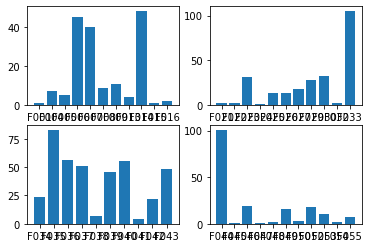

Calculating stats for: 
- Year = 2016 
- Category = SEATING DETAILS
This is resultsAv: 
                      mean  median                mode
SEATING DETAILS                                       
0-30             94.766667    95.0              [95.0]
1-1,999          83.000000    83.0              [83.0]
1-1,999 SF       95.647059    96.0  [94.0, 96.0, 98.0]
151 +            95.500000    95.5        [95.0, 96.0]
2,000+ SF        95.000000    95.0        [92.0, 98.0]
31-60            91.722222    92.0              [90.0]
61-150           91.500000    91.5              [98.0]


In [22]:
ui = UserInterface('summative')
ui.createWindow()

In [21]:
test = collection_vendors.find({'_id': {'$regex':'DA'}})
for t in test:
    print(t)

In [66]:
ui = UserInterface('summative')
ui.createCorrelationsPlot()


In [78]:
window = Tk()
window.title('test')
window.geometry("1200x800")
window.columnconfigure(0, weight=1)
window.rowconfigure(0, weight=1)

mainframe = ttk.Notebook(window) #tree = ttk.Treeview(mainframe)
f1 = ttk.Frame(mainframe)  
f2 = ttk.Frame(mainframe)  
f3 = ttk.Frame(mainframe) 
mainframe.add(f1, text='Averages')
mainframe.add(f2, text='Violations per Establishment')
mainframe.add(f3, text='Correlations')
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))

frame=Frame(f1)
frame.pack(expand=True, fill=BOTH)
canvas=Canvas(frame,bg='#FFFFFF',width=300,height=300,scrollregion=(0,0,500,1300))
canvas.pack()

for i in range(50):
    Label(frame,text="my text"+str(i)).pack()

# frameScrollY = Scrollbar(frame, orient='vertical', command=canvas.yview)
# canvas.configure(yscrollcommand=frameScrollY.set)
# frameScrollY.pack(side="right",fill="y")



# frame=Frame(root,width=300,height=300)
# frame.pack(expand=True, fill=BOTH) #.grid(row=0,column=0)
# canvas=Canvas(frame,bg='#FFFFFF',width=300,height=300,scrollregion=(0,0,500,500))

vbar=Scrollbar(frame,orient=VERTICAL)
vbar.pack(side=RIGHT,fill=Y)
vbar.config(command=canvas.yview)
canvas.config(width=300,height=300)
canvas.config(yscrollcommand=vbar.set)
canvas.pack(side=LEFT,expand=True,fill=BOTH)



window.mainloop()

In [202]:

# root=Tk()
# frame=Frame(window,width=300,height=300)
# frame.pack(expand=True, fill=BOTH) #.grid(row=0,column=0)
# canvas=Canvas(frame,bg='#FFFFFF',width=300,height=300,scrollregion=(0,0,500,500))

window = Tk()
window.title('test')
window.geometry("1200x800")
window.columnconfigure(0, weight=1)
window.rowconfigure(0, weight=1)

mainframe = ttk.Notebook(window) #tree = ttk.Treeview(mainframe)
f1 = ttk.Frame(mainframe)  
f2 = ttk.Frame(mainframe)  
f3 = ttk.Frame(mainframe) 
mainframe.add(f1, text='Averages')
mainframe.add(f2, text='Violations per Establishment')
mainframe.add(f3, text='Correlations')
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))

frame=Frame(f1,width=300,height=500)
frame.pack(expand=True, fill=BOTH) #.grid(row=0,column=0)
canvas=Canvas(frame,bg='#FFFFFF',width=300,height=500, scrollregion=(0,0,1000,1000))
# canvas.configure(scrollregion=canvas.bbox("all"))

vbar=Scrollbar(frame,orient=VERTICAL)
vbar.pack(side=RIGHT,fill=Y)
vbar.config(command=canvas.yview)
canvas.config(width=300,height=500)
canvas.config(yscrollcommand=vbar.set)
canvas.pack(side=LEFT,expand=True,fill=BOTH)

root.mainloop()

  Init canvas.bbox: (0, 0, 600, 600) mplCanvas.bbox: (0, 0, 600, 600)


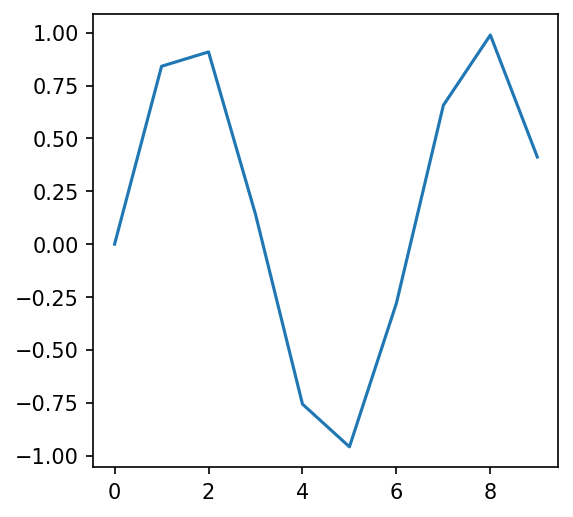

In [4]:
import pprint
import tkinter.constants as Tkconstants
import math

frame = None
canvas = None

def printBboxes(label=""):
    global canvas, mplCanvas, interior, interior_id, cwid
    print("  "+label,
    "canvas.bbox:", canvas.bbox(Tkconstants.ALL),
    "mplCanvas.bbox:", mplCanvas.bbox(Tkconstants.ALL))

def addScrollingFigure(figure, frame):
    global canvas, mplCanvas, interior, interior_id, cwid
    # set up a canvas with scrollbars
    canvas = Canvas(frame)
    canvas.grid(row=1, column=1, sticky=Tkconstants.NSEW)

    xScrollbar = Scrollbar(frame, orient=Tkconstants.HORIZONTAL)
    yScrollbar = Scrollbar(frame)

    xScrollbar.grid(row=2, column=1, sticky=Tkconstants.EW)
    yScrollbar.grid(row=1, column=2, sticky=Tkconstants.NS)
    
    canvas.config(xscrollcommand=xScrollbar.set)
    xScrollbar.config(command=canvas.xview)
    canvas.config(yscrollcommand=yScrollbar.set)
    yScrollbar.config(command=canvas.yview)

    # plug in the figure
    figAgg = FigureCanvasTkAgg(figure, canvas)
    mplCanvas = figAgg.get_tk_widget()
    #mplCanvas.grid(sticky=Tkconstants.NSEW)

    # and connect figure with scrolling region
    cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
    printBboxes("Init")
    canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=200,height=200)

# def changeSize(figure, factor):
#     global canvas, mplCanvas, interior, interior_id, frame, cwid
#     oldSize = figure.get_size_inches()
#     print("old size is", oldSize)
#     figure.set_size_inches([factor * s for s in oldSize])
#     wi,hi = [i*figure.dpi for i in figure.get_size_inches()]
#     print("new size is", figure.get_size_inches())
#     print("new size pixels: ", wi,hi)
#     mplCanvas.config(width=wi, height=hi) ; printBboxes("A")
#     #mplCanvas.grid(sticky=Tkconstants.NSEW)
#     canvas.itemconfigure(cwid, width=wi, height=hi) ; printBboxes("B")
#     canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=200,height=200)
#     figure.canvas.draw() ; printBboxes("C")
#     print()

# if __name__ == "__main__":
root = Tk()
root.rowconfigure(1, weight=1)
root.columnconfigure(1, weight=1)

frame = Frame(root)
frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
frame.rowconfigure(1, weight=1)
frame.columnconfigure(1, weight=1)

figure = plt.figure(dpi=150, figsize=(4, 4))
plt.plot(range(10), [math.sin(x) for x in range(10)])

addScrollingFigure(figure, frame)

buttonFrame = Frame(root)
buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
biggerButton = Button(buttonFrame, text="larger",
                    command=lambda : changeSize(figure, 1.5))
biggerButton.grid(column=1, row=1)
smallerButton = Button(buttonFrame, text="smaller",
                     command=lambda : changeSize(figure, .5))
smallerButton.grid(column=1, row=2)

root.mainloop()

In [3]:
from tkinter import messagebox 


  
# messagebox.showinfo("showinfo", "Information") 

messagebox.showinfo(title='Save to database', message='You data has now been cleaned. Please press "ok" to proceed and load the data into a database.')


'yes'